### 総合演習データパイプライン

* 入力：CSVファイル ("C:\Users\Admin\ILP\Python-AI\raw_data.csv")
* FeatherL:C:\Users\81803\ILP\Python-AI\merged_data.feather
* 出力：

In [1]:
#必要なライブラリ
import pandas as pd
import numpy as np
import pyarrow.feather as feather
from sklearn.preprocessing import LabelEncoder

In [137]:
df = pd.read_csv('newrawdata.csv',encoding='utf-8')
df['日付'] = pd.to_datetime(df['日付'], infer_datetime_format=True)

df

C:\Users\81803\AppData\Local\Temp\ipykernel_6072\3434063758.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['日付'] = pd.to_datetime(df['日付'], infer_datetime_format=True)


,日付,曜日,予約件数,予約人数,来客数,総杯数,売上合計(円),ペールエール(本),ペールエール(円),ラガー(本),ラガー(円),IPA(本),IPA(円),ホワイトビール(本),ホワイトビール(円),黒ビール(本),黒ビール(円),フルーツビール(本),フルーツビール(円)
0,2024-04-01,月,NaN,NaN,16,25,25300,6,6000,5,4000,5,4500,4,3600,6,7200,0,0
1,2024-04-02,火,NaN,NaN,19,25,24600,6,6000,4,3200,5,4500,3,2700,6,7200,1,1000
2,2024-04-03,水,NaN,NaN,11,19,18500,5,5000,4,3200,3,2700,2,1800,4,4800,1,1000
3,2024-04-04,木,NaN,NaN,6,10,9500,2,2000,2,1600,2,1800,1,900,1,1200,2,2000
4,2024-04-05,金,NaN,NaN,10,18,17100,3,3000,5,4000,3,2700,2,1800,3,3600,2,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,2025-03-27,木,NaN,NaN,10,14,13400,2,2000,3,2400,2,1800,2,1800,2,2400,3,3000
310,2025-03-28,金,NaN,NaN,14,28,26900,6,6000,7,5600,3,2700,4,3600,5,6000,3,3000
311,2025-03-29,土,NaN,NaN,6,8,7600,2,2000,2,1600,1,900,1,900,1,1200,1,1000
312,2025-03-31,月,NaN,NaN,9,15,14800,4,4000,2,1600,2,1800,2,1800,3,3600,2,2000


In [14]:
import pandas as pd

df = pd.read_csv('./data/raw_data.csv', encoding='utf-8')

# 1. 过滤掉 '日付'、空行或其它异常值
mask = df['日付'].astype(str).str.match(r'^\d{4}/\d{1,2}/\d{1,2}$')
df = df.loc[mask].copy()

# 2. 解析为 datetime
df['日付'] = pd.to_datetime(df['日付'], infer_datetime_format=True)

# 3. 验证
print(df['日付'].head())
print(df.info())


0   2024-04-01
1   2024-04-02
2   2024-04-03
3   2024-04-04
4   2024-04-05
Name: 日付, dtype: datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 0 to 325
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   日付          315 non-null    datetime64[ns]
 1   予約件数        28 non-null     object        
 2   予約人数        47 non-null     object        
 3   来客数         314 non-null    object        
 4   総杯数         314 non-null    object        
 5   売上合計(円)     313 non-null    object        
 6   ペールエール(本)   310 non-null    object        
 7   ペールエール(円)   310 non-null    object        
 8   ラガー(本)      307 non-null    object        
 9   ラガー(円)      307 non-null    object        
 10  IPA(本)      286 non-null    object        
 11  IPA(円)      285 non-null    object        
 12  ホワイトビール(本)  259 non-null    object        
 13  ホワイトビール(円)  257 non-null    object        
 14  黒ビール(本)     233 non-

C:\Users\81803\AppData\Local\Temp\ipykernel_6072\2808381903.py:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['日付'] = pd.to_datetime(df['日付'], infer_datetime_format=True)


In [15]:
# 定义包含各品类销售额的列名
sales_cols = [
    'ペールエール(円)',
    'ラガー(円)',
    'IPA(円)',
    'ホワイトビール(円)',
    '黒ビール(円)',
    'フルーツビール(円)'
]

# 去掉千分位逗号并转成数值
for col in sales_cols + ['売上合計(円)']:
    df[col] = (
        df[col]
        .fillna('0')            # 将 NaN 当作 "0" 处理
        .astype(str)
        .str.replace(',', '')   # 移除逗号
        .astype(float)          # 转为 float
    )

# 重新计算総売上額
df['総売上額'] = df[sales_cols].sum(axis=1)

# 查看原始合计和重新计算的对比
print(df[['日付', '売上合計(円)', '総売上額']].head())


          日付  売上合計(円)     総売上額
0 2024-04-01  31800.0  31800.0
1 2024-04-02  23300.0  23300.0
2 2024-04-03  33600.0  33600.0
3 2024-04-04  24600.0  24600.0
4 2024-04-05  56500.0  56500.0


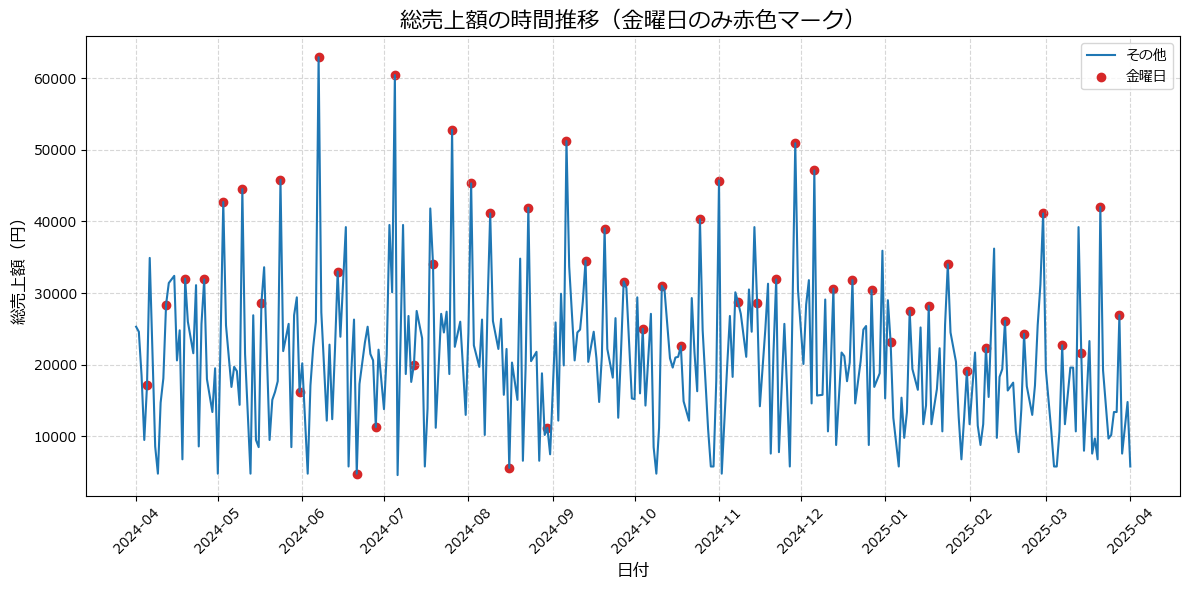

In [132]:
# ...existing code...
dates = df['日付']
sales = df['売上合計(円)']
friday_mask = dates.dt.weekday == 4  # 金曜日のみ

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dates, sales, linestyle='-', label='その他', color='tab:blue')
ax.scatter(dates[friday_mask], sales[friday_mask],
           color='tab:red', marker='o', label='金曜日')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax.legend()
ax.set_title('総売上額の時間推移（金曜日のみ赤色マーク）', fontsize=16)
ax.set_xlabel('日付', fontsize=12)
ax.set_ylabel('総売上額（円）', fontsize=12)

ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
# ...existing code...

In [188]:
mergeddf.to_json('mergeddf.json', orient='records', force_ascii=False, indent=4)
mergeddf.to_feather('mergeddf.feather')

In [189]:
df = feather.read_feather('mergeddf.feather')
df.columns.unique()

Index(['日付', '曜日', '来客数', '総杯数', '売上合計(円)', 'ペールエール(本)', 'ペールエール(円)_x',
       'ラガー(本)', 'ラガー(円)_x', 'IPA(本)', 'IPA(円)_x', 'ホワイトビール(本)',
       'ホワイトビール(円)_x', '黒ビール(本)', '黒ビール(円)_x', 'フルーツビール(本)', 'フルーツビール(円)_x',
       '平均気温(℃)', '日照時間(時間)', '降雪量合計(cm)', '平均湿度(％)', '最高気温(℃)', '最低気温(℃)',
       '10分間降水量の最大(mm)', '天気概況(昼：06時～18時)', '天気概況(夜：18時～翌日06時)'],
      dtype='object')

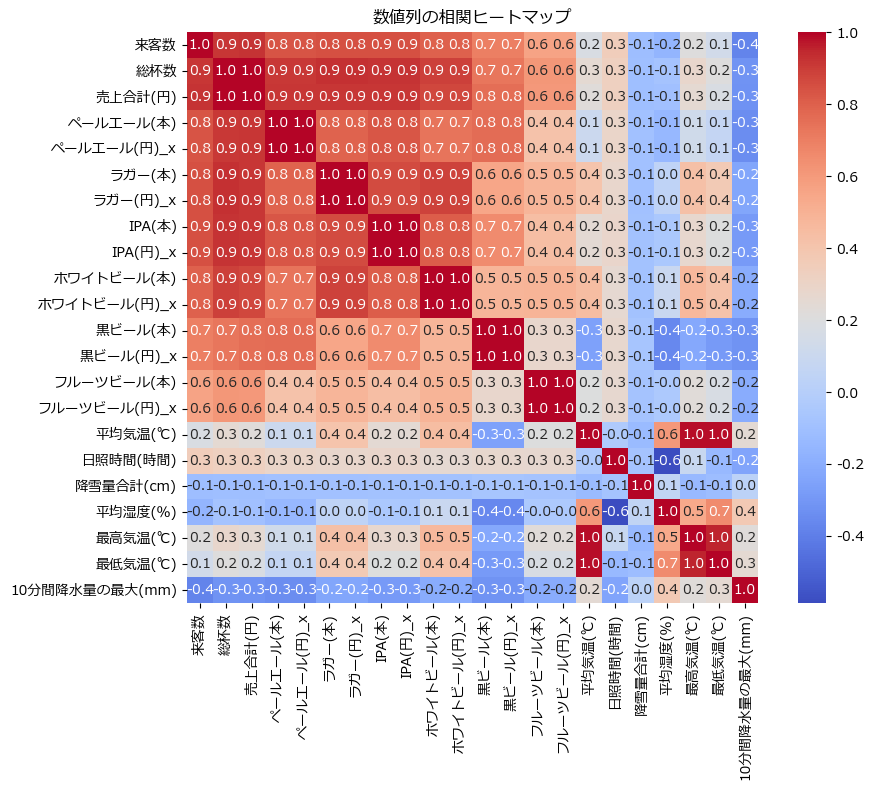

In [191]:
# ...existing code...
import seaborn as sns
import matplotlib.pyplot as plt

# 数値列のみ抽出
corr = df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".1f", cmap='coolwarm', square=True)
plt.title('数値列の相関ヒートマップ')
plt.tight_layout()
plt.show()
# ...existing code...

In [193]:
df['date'] = pd.to_datetime(df['日付'])
df = df.sort_values('date')
df['weekday']    = df['date'].dt.weekday        # 0=周一…6=周日  
df['is_weekend'] = df['weekday'] >= 5            # 周末标记  
df['month']      = df['date'].dt.month  
df['dayofyear']  = df['date'].dt.dayofyear  


In [194]:
beer_list = [
    'ペールエール(本)',
    'ラガー(本)',
    'IPA(本)',
    'ホワイトビール(本)',
    '黒ビール(本)',
    'フルーツビール(本)'
]
for beer in beer_list:
    df[f'{beer}_lag1'] = df[beer].shift(1)
    df[f'{beer}_ma7']  = df[beer].rolling(7).mean().shift(1)


In [195]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)


In [206]:
import pandas as pd
import numpy as np
import jpholiday
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. 读取数据
# 根据实际情况修改路径与格式
# df = pd.read_csv('mergeddf.csv', parse_dates=['日付'])
df = pd.read_feather('mergeddf.feather')

# 2. 构造日期特征与节假日
df['日付']      = pd.to_datetime(df['日付'])
df['weekday']   = df['日付'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['month']     = df['日付'].dt.month
df['dayofyear'] = df['日付'].dt.dayofyear
# 日本法定节假日
df['is_holiday'] = df['日付'].apply(lambda x: int(jpholiday.is_holiday(x)))

# 3. 气象特征与缺失值处理
weather_cols = [
    '平均気温(℃)', '最高気温(℃)', '最低気温(℃)',
    '10分間降水量の最大(mm)', '日照時間(時間)', '平均湿度(％)'
]
df[weather_cols] = SimpleImputer(strategy='mean').fit_transform(df[weather_cols])

# 4. 定义特征列和目标列
target_cols = [
    'ペールエール(本)', 'ラガー(本)', 'IPA(本)',
    'ホワイトビール(本)', '黒ビール(本)', 'フルーツビール(本)'
]
feature_cols = [
    'weekday', 'is_weekend', 'month', 'dayofyear', 'is_holiday'
] + weather_cols

X = df[feature_cols]
y = df[target_cols]

# 5. 缺失值填充和标准化
imputer = SimpleImputer(strategy='mean')
X_imp = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# 6. 时序交叉验证与 MLPRegressor 网格搜索
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'alpha': [1e-4, 1e-3],
    'learning_rate_init': [1e-3, 1e-2]
}
mlp = MLPRegressor(random_state=42, max_iter=500)
grid = GridSearchCV(
    mlp, param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid.fit(X_scaled, y)
print("Best parameters:", grid.best_params_)

# 7. 留最后 30 天做测试评估
X_train, X_test = X_scaled[:-30], X_scaled[-30:]
y_train, y_test = y.iloc[:-30], y.iloc[-30:]
best_mlp = grid.best_estimator_
best_mlp.fit(X_train, y_train)
y_pred = best_mlp.predict(X_test)

# 8. 输出评估结果
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"Test R2 : {r2_score(y_test, y_pred):.3f}")


c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
Test MSE: 3.384
Test R2 : 0.172


c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [208]:
import pandas as pd
import numpy as np
import jpholiday
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. 读取数据
# 根据实际情况修改路径与格式
# df = pd.read_csv('mergeddf.csv', parse_dates=['日付'])
df = pd.read_feather('mergeddf.feather')

# 2. 构造日期特征与节假日
df['日付']      = pd.to_datetime(df['日付'])
df['weekday']   = df['日付'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['month']     = df['日付'].dt.month
df['dayofyear'] = df['日付'].dt.dayofyear
# 日本法定节假日
df['is_holiday'] = df['日付'].apply(lambda x: int(jpholiday.is_holiday(x)))

# 3. 主要气象特征与缺失值处理
weather_cols = [
    '10分間降水量の最大(mm)', '日照時間(時間)', '平均湿度(％)'
]
df[weather_cols] = SimpleImputer(strategy='mean').fit_transform(df[weather_cols])

# 4. 计算总销售量作为单一目标
target_cols = [
    'ペールエール(本)', 'ラガー(本)', 'IPA(本)',
    'ホワイトビール(本)', '黒ビール(本)', 'フルーツビール(本)'
]
df['total_sales'] = df[target_cols].sum(axis=1)

# 5. 准备特征矩阵和目标向量
feature_cols = [
    'weekday', 'is_weekend', 'month', 'dayofyear', 'is_holiday'
] + weather_cols
X = df[feature_cols]
y = df['total_sales']

# 6. 特征预处理：填补 & 标准化
X_imp = SimpleImputer(strategy='mean').fit_transform(X)
X_scaled = StandardScaler().fit_transform(X_imp)

# 7. 时序交叉验证与神经网络网格搜索
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'alpha': [1e-4, 1e-3],
    'learning_rate_init': [1e-3, 1e-2]
}
mlp = MLPRegressor(random_state=42, max_iter=500)
grid = GridSearchCV(
    mlp, param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid.fit(X_scaled, y)
print("Best parameters:", grid.best_params_)

# 8. 最后 30 天做测试评估
X_train, X_test = X_scaled[:-30], X_scaled[-30:]
y_train, y_test = y.iloc[:-30], y.iloc[-30:]
best_mlp = grid.best_estimator_
best_mlp.fit(X_train, y_train)
y_pred = best_mlp.predict(X_test)

# 9. 输出评估结果
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"Test R2 : {r2_score(y_test, y_pred):.3f}")


c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters: {'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001}
Test MSE: 86.864
Test R2 : 0.244


c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


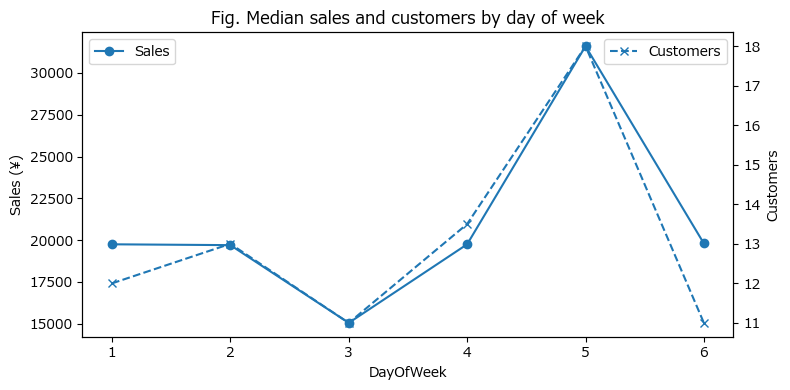

In [214]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 读取数据
df = pd.read_feather('mergeddf.feather')

# 2. 确保日期列为 datetime，并提取星期几（1=星期一,…,7=星期日）
df['日付'] = pd.to_datetime(df['日付'])
df['DayOfWeek'] = df['日付'].dt.weekday + 1

# 3. 计算中位数
median_sales     = df.groupby('DayOfWeek')['売上合計(円)'].median()
median_customers = df.groupby('DayOfWeek')['来客数'].median()

# 4. 绘图
fig, ax1 = plt.subplots(figsize=(8, 4))

# 左轴：销售额
ax1.plot(median_sales.index,
         median_sales.values,
         marker='o',
         label='Sales')
ax1.set_xlabel('DayOfWeek')
ax1.set_ylabel('Sales (¥)')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# 右轴：来客数
ax2 = ax1.twinx()
ax2.plot(median_customers.index,
         median_customers.values,
         marker='x',
         linestyle='--',
         label='Customers')
ax2.set_ylabel('Customers')
ax2.legend(loc='upper right')

# 标题 & 美化
plt.title('Fig. Median sales and customers by day of week')
plt.tight_layout()
plt.show()


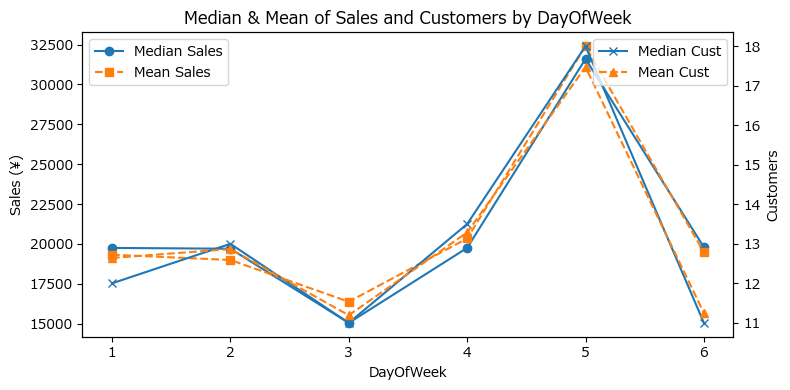

In [215]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 读取数据
df = pd.read_feather('mergeddf.feather')
df['日付'] = pd.to_datetime(df['日付'])
df['DayOfWeek'] = df['日付'].dt.weekday + 1

# 2. 计算中位数和平均数
grp = df.groupby('DayOfWeek')
median_sales     = grp['売上合計(円)'].median()
mean_sales       = grp['売上合計(円)'].mean()
median_customers = grp['来客数'].median()
mean_customers   = grp['来客数'].mean()

# 3. 绘图
fig, ax1 = plt.subplots(figsize=(8, 4))

# 销售额：中位数和平均数
ax1.plot(median_sales.index, median_sales.values,   marker='o', label='Median Sales')
ax1.plot(mean_sales.index,   mean_sales.values,     marker='s', linestyle='--', label='Mean Sales')
ax1.set_xlabel('DayOfWeek')
ax1.set_ylabel('Sales (¥)')
ax1.legend(loc='upper left')

# 来客数：中位数和平均数
ax2 = ax1.twinx()
ax2.plot(median_customers.index, median_customers.values, marker='x', label='Median Cust')
ax2.plot(mean_customers.index,   mean_customers.values,   marker='^', linestyle='--', label='Mean Cust')
ax2.set_ylabel('Customers')
ax2.legend(loc='upper right')

plt.title('Median & Mean of Sales and Customers by DayOfWeek')
plt.tight_layout()
plt.show()


C:\Users\81803\AppData\Local\Temp\ipykernel_6072\1188712971.py:47: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\1188712971.py:47: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\1188712971.py:47: UserWarning: Glyph 21183 (\N{CJK UNIFIED IDEOGRAPH-52BF}) missing from font(s) Meiryo.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) Meiryo.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) Meiryo.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-pac

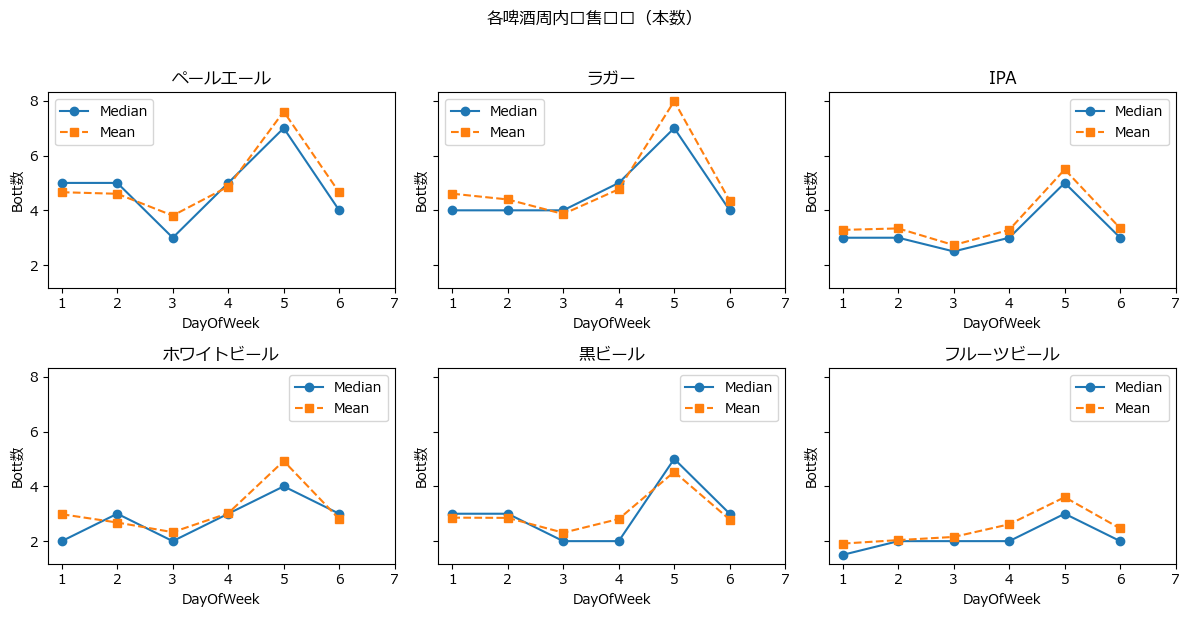

In [216]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 读数据并生成 DayOfWeek
df = pd.read_feather('mergeddf.feather')
df['日付'] = pd.to_datetime(df['日付'])
df['DayOfWeek'] = df['日付'].dt.weekday + 1   # 1=周一…7=周日

# 2. 定义啤酒品类（对应“本”列）
beer_list = [
    'ペールエール',
    'ラガー',
    'IPA',
    'ホワイトビール',
    '黒ビール',
    'フルーツビール'
]

# 3. 绘制 2×3 子图
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True)
for ax, beer in zip(axes.flatten(), beer_list):
    col = f'{beer}(本)'
    grp = df.groupby('DayOfWeek')[col]
    
    median_vals = grp.median()
    mean_vals   = grp.mean()
    
    # 中位数
    ax.plot(median_vals.index, 
            median_vals.values,
            marker='o',
            label='Median')
    # 平均数
    ax.plot(mean_vals.index,
            mean_vals.values,
            marker='s',
            linestyle='--',
            label='Mean')
    
    ax.set_title(beer)
    ax.set_xlabel('DayOfWeek')
    ax.set_ylabel('Bott数')
    ax.set_xticks(range(1,8))
    ax.legend()

plt.suptitle('各啤酒周内销售趋势（本数）', y=1.02)
plt.tight_layout()
plt.show()


C:\Users\81803\AppData\Local\Temp\ipykernel_6072\3929606260.py:28: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\3929606260.py:28: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\3929606260.py:28: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\3929606260.py:28: UserWarning: Glyph 21183 (\N{CJK UNIFIED IDEOGRAPH-52BF}) missing from font(s) Meiryo.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) Meiryo.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: U

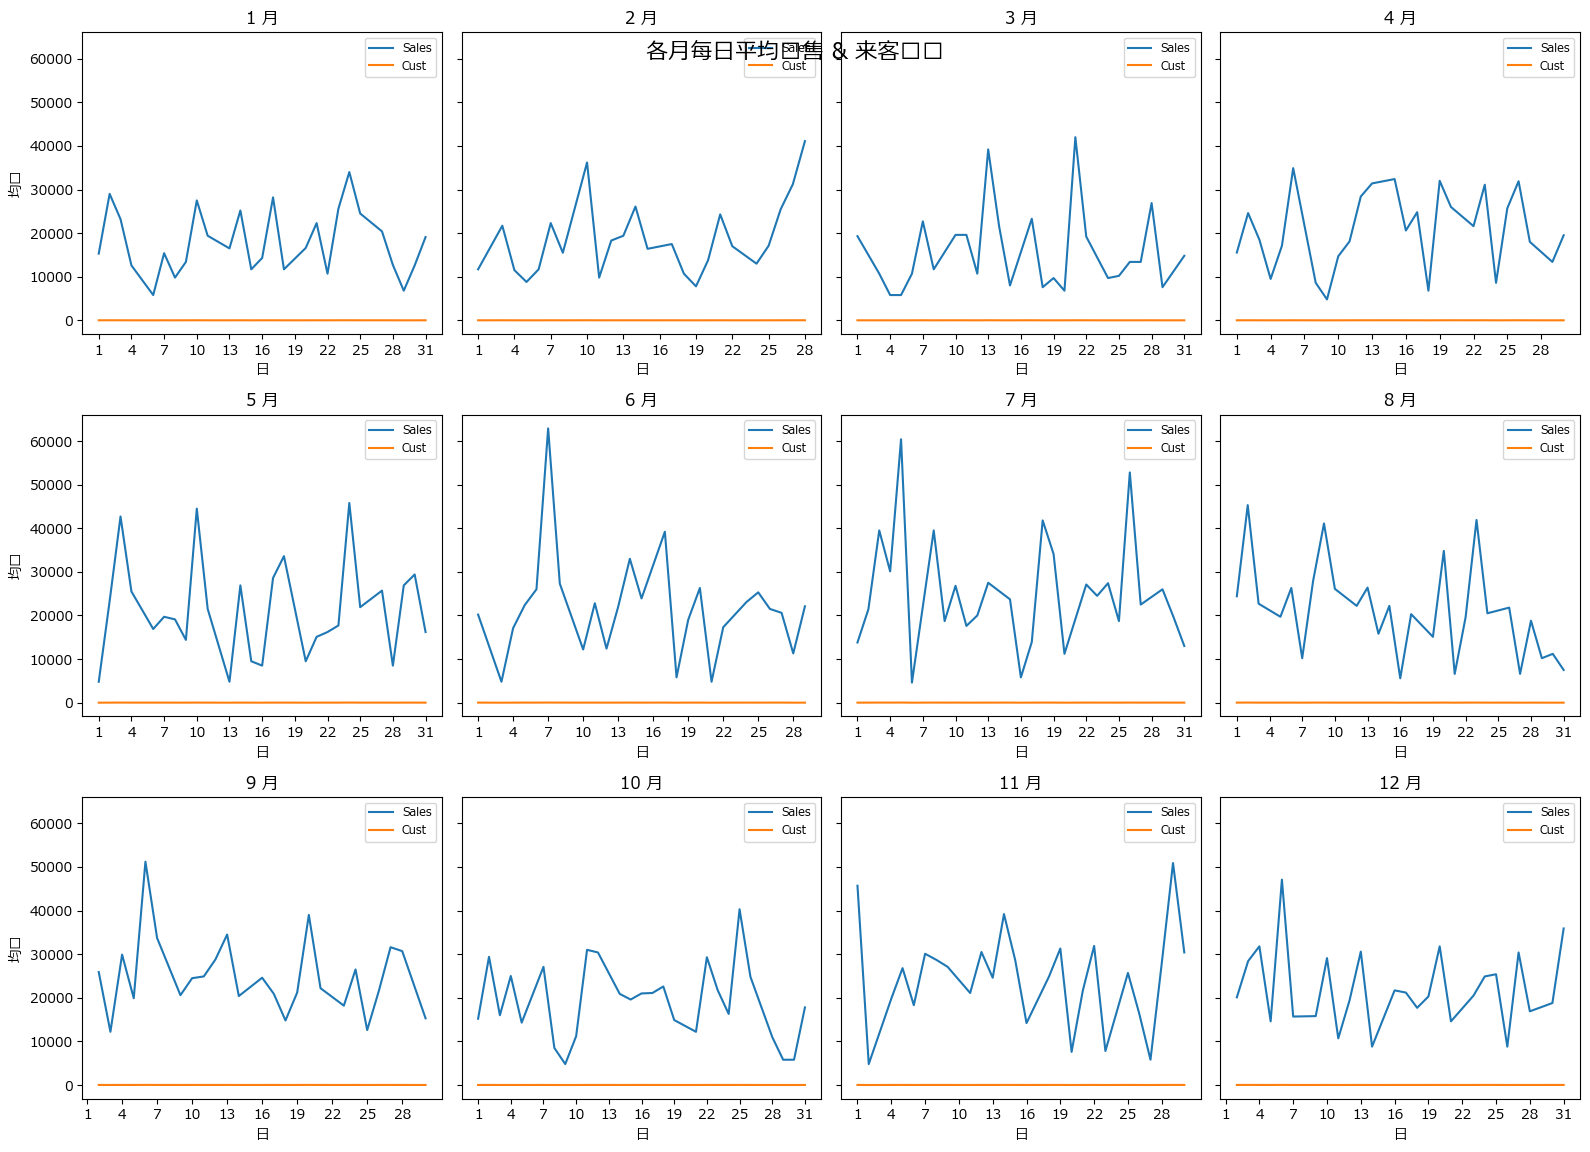

In [221]:
import pandas as pd
import matplotlib.pyplot as plt

# 读数据＋提取月、日
df = pd.read_feather('mergeddf.feather')
df['日付'] = pd.to_datetime(df['日付'])
df['Month'] = df['日付'].dt.month
df['Day']   = df['日付'].dt.day

# 准备绘图
fig, axes = plt.subplots(3, 4, figsize=(16, 12), sharey=True)
for m, ax in enumerate(axes.flatten(), start=1):
    sub = df[df['Month'] == m].groupby('Day')
    # 取平均，也可以换成 median()
    mean_sales     = sub['売上合計(円)'].mean()
    mean_customers = sub['来客数'].mean()
    
    ax.plot(mean_sales.index,     mean_sales.values,     label='Sales')
    ax.plot(mean_customers.index, mean_customers.values, label='Cust')
    ax.set_title(f'{m} 月')
    ax.set_xlabel('日')
    ax.set_xticks(range(1, mean_sales.index.max()+1, 3))
    if m % 4 == 1:
        ax.set_ylabel('均值')
    ax.legend(fontsize='small')

plt.suptitle('各月每日平均销售 & 来客趋势', y=0.93, fontsize=16)
plt.tight_layout()
plt.show()


C:\Users\81803\AppData\Local\Temp\ipykernel_6072\2412102887.py:39: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) Meiryo.
  plt.tight_layout()
C:\Users\81803\AppData\Local\Temp\ipykernel_6072\2412102887.py:39: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) Meiryo.
  plt.tight_layout()
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from font(s) Meiryo.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\miniconda3\envs\ILP\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from font(s) Meiryo.
  fig.canvas.print_figure(bytes_io, **kw)


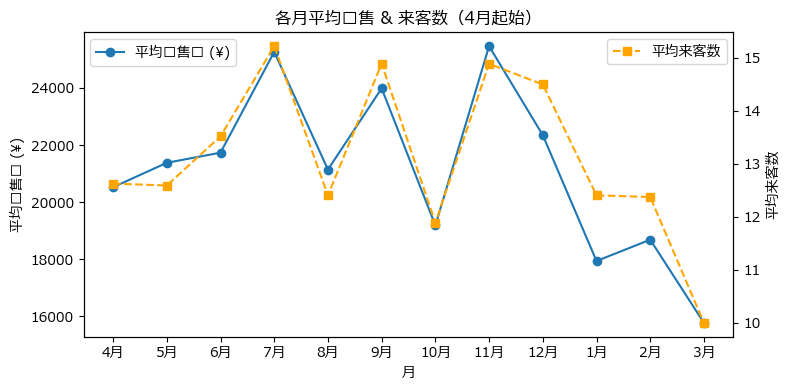

In [227]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 读取 & 预处理
df = pd.read_feather('mergeddf.feather')
df['日付'] = pd.to_datetime(df['日付'])
df.set_index('日付', inplace=True)

# 2. 按“月份”聚合取平均（跨年也只会得到 1–12 共 12 条）
monthly_sales = df['売上合計(円)'].groupby(df.index.month).mean()
monthly_cust  = df['来客数'].groupby(df.index.month).mean()

# 3. 指定财政年（4月–3月）的顺序
order = list(range(4, 13)) + [1, 2, 3]
monthly_sales = monthly_sales.reindex(order)
monthly_cust  = monthly_cust.reindex(order)

# 4. 绘图
fig, ax1 = plt.subplots(figsize=(8, 4))

x = list(range(len(order)))  # 0,1,2,...,11
labels = [f'{m}月' for m in order]

ax1.plot(x, monthly_sales.values,
         marker='o', label='平均销售额 (¥)')
ax1.set_xlabel('月')
ax1.set_ylabel('平均销售额 (¥)')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(x, monthly_cust.values,
         marker='s', linestyle='--', color='orange', label='平均来客数')
ax2.set_ylabel('平均来客数')
ax2.legend(loc='upper right')

plt.title('各月平均销售 & 来客数（4月起始）')
plt.tight_layout()
plt.show()
